# Tutorial 3: Finetuning on a New Single-Cell Dataset

In this tutorial, we will demonstrate how to fine-tune an existing Cell2Sentence (C2S) model on a new single-cell RNA sequencing dataset. Fine-tuning is a crucial step in adapting a pretrained model to perform well on a specific task or dataset, improving its accuracy and generalization. This tutorial will guide you through the process of fine-tuning a C2S model to perform cell type prediction on a new dataset.

In this tutorial, you will:
1. Load an immune tissue single-cell dataset from Domínguez Conde et al. (preprocessed in tutorial notebook 0, two sample donors)
    - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
2. Format the dataset using a Prompt Formatter object, which prepares the data for the fine-tuning process.
3. Load a pretrained C2S model.
4. Fine-tune the C2S model to improve its performance on cell type prediction.

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [1]:
# Python built-in libraries
import os
from datetime import datetime
import random
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm
from transformers import TrainingArguments

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [3]:
DATA_PATH = "/data/Mamba/Project/Single_Cell/Benchmark/Cell2Setence/Data/D099_processed_w_cell2sentence.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 15806 × 25819
    obs: 'donor_id', 'batch', 'cell_type', 'disease', 'tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'author_cell_type_colors', 'cell_type_colors', 'disease_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs = adata.obs[["cell_type", "disease", "tissue", "organism"]]

In [6]:
adata.obs.head()

,cell_type,disease,tissue,organism
N2_O1_AAACGAAAGTCGCCAC-1,Differentiating.Basal,normal,lung,lung
N2_O1_AAACGAAGTTAGCTAC-1,Differentiating.Basal,normal,lung,lung
N2_O1_AAACGAATCCTCTCTT-1,Differentiating.Basal,normal,lung,lung
N2_O1_AAACGCTCACTGCACG-1,Basal,normal,lung,lung
N2_O1_AAAGAACGTAGCTCGC-1,Suprabasal,normal,lung,lung


In [7]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,AL627309.1,ENSG00000238009,676,False,676,0.006523,95.723143,103.096534
AL627309.5,AL627309.5,ENSG00000241860,929,False,929,0.008854,94.122485,139.943934
AL627309.4,AL627309.4,ENSG00000241599,14,False,14,0.000276,99.911426,4.358894
AP006222.2,AP006222.2,ENSG00000286448,57,False,57,0.000484,99.639377,7.646652
LINC01409,LINC01409,ENSG00000237491,3032,False,3032,0.036046,80.817411,569.739271


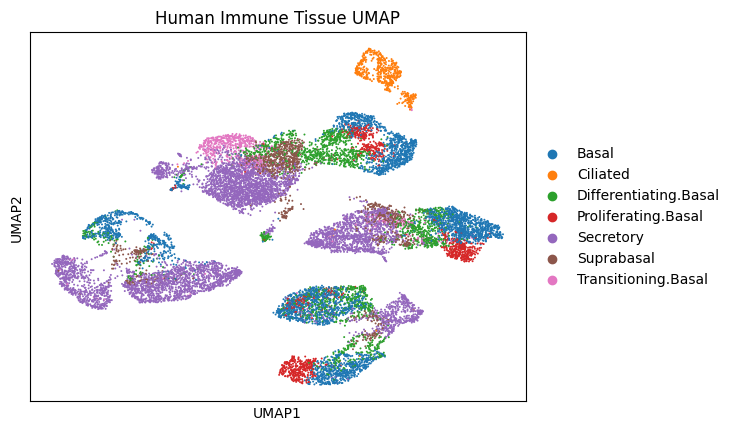

In [8]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [9]:
adata.X.max()

np.float64(1.2421381363878892)

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion + CSData Creation

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [10]:
adata_obs_cols_to_keep = adata.obs.columns.tolist()
adata_obs_cols_to_keep

['cell_type', 'disease', 'tissue', 'organism']

In [11]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

WARN: more variables (25819) than observations (15806)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (25819) than observations (15806), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 15806/15806 [01:01<00:00, 257.77it/s]


In [12]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'N2_O1_AAACGAAAGTCGCCAC-1',
 'cell_sentence': 'MT-CO2 MT-CO1 MT-CYB KRT19 MT-CO3 MT-ATP6 S100A6 MT-ND4 MT-ND3 KRT6A GAPDH SAT1 TPT1 RPS18 MIF SPINK5 RPL13 S100A11 RPS2 EEF1A1 RPLP1 CSTB FXYD3 H19 TMSB10 SERPINB3 RPS8 RPS12 RPL7A RPL41 TMSB4X MT-ND2 MT-ND5 RPS14 RPL10 RPS6 RPL28 RPS3A RPL15 RPL8 GSTP1 RPS19 RPS4X RPL11 RPL13A CD9 MT-ND1 RPL29 RPS24 RPS23 KRT18 RPS3 RPL6 RPL17 RPL23A RPL12 ANXA2 RPL18 RPS15 RPL18A CEACAM5 RPLP0 S100A10 RPS27A RPL3 FTH1 GSN RPS7 RPL26 RPL32 KRT8 RPL37A ENO1 RPL19 RPL10A RPS9 RPLP2 RPL9 RPL14 RPS28 RPS16 RPL27A RPL36 RPSA SERPINB4 RPS15A RACK1 RPS5 RPL35 TXN RPL30 RPL37 RPL21 H3F3A ATP5F1E RPS27 RPS13 RPS21 RPS29 RPL34 FAU RPL35A CTSB GPX2 SFN RPL24 RPL5 MYL6 RPL7 SERF2 EEF1G RPS11 PTMA CST3 KRT5 H3F3B HSP90AA1 RPS17 MALAT1 TPI1 RPL36A HSP90AB1 NACA ACTB PPDPF ACTG1 EZR PKM NME2 RPL39 RPL27 RPS25 FGFBP1 PERP UBA52 RPL38 CALM1 SERPINB1 RPL22 ATP1B1 UBC PGK1 ADIRF TXNDC17 EIF1 SPRR3 BCAT1 MYOF TUBB4B TSPO S100A14 RPL23 EEF1B2 PRDX2 OAZ1 PPIA EI

In [13]:
c2s_save_dir = "/home/scbjtfy/cell2sentence/tutorials/cell_type_pred_pythia_410M_inference"  # C2S dataset will be saved into this directory
c2s_save_name = "cell_annotation_with_finetune"  # This will be the name of our C2S dataset on disk

In [14]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/2 shards):   0%|          | 0/15806 [00:00<?, ? examples/s]

In [15]:
print(csdata)

CSData Object; Path=/home/scbjtfy/cell2sentence/tutorials/cell_type_pred_pythia_410M_inference/cell_annotation_with_finetune, Format=arrow


# Load C2S Model

Now, we will load a C2S model which will finetune on a new dataset. This model can be a LLM pretrained on natural language, or it can be a trained C2S model which will undergo further finetuning on a new dataset of interest. Typically, starting from a pretrained C2S model benefits performance, since C2S models were initialized from natural language-pretrained LLMs and trained on many single-cell datasets on different tasks.

For this tutorial, we will start finetuning from the C2S-Pythia-410M cell type prediction model, which was trained to do cell type prediction on many datasets from CellxGene and Human Cell Atlas. We will finetune it for cell type prediction on our immune tissue dataset which we have loaded, which will help align the model with the cell type annotations present in this dataset as well as the expression profiles of the cells in our two donor samples. More details about the C2S-Pythia-410M cell type prediction model can be found in the Model Zoo section of the ReadME in the GitHub repo, or in the Huggingface model card.

We can define our CSModel object with our pretrained cell type prediction model as follows:

In [17]:
# Define CSModel object
cell_type_prediction_model_path = "/data/Mamba/Data/hf_cache/hub/models--vandijklab--C2S-Pythia-410m-cell-type-prediction/snapshots/5a4dc3b949b5868ca63752b37bc22e3b0216e435"
save_dir = "./"
save_name = "cell_type_pred_pythia_410M_inference"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


Note that the `model_name_or_path` parameter can be a name of a Huggingface model, for example 'EleutherAI/pythia-410m' for a 410 million parameter Pythia model pretrained on natural language (see https://huggingface.co/EleutherAI/pythia-410m), or it can be the path to a pretrained model saved on disk, as in the case in the cell above.

In [18]:
print(csmodel)

CSModel Object; Path=./cell_type_pred_pythia_410M_inference


# Finetune on new dataset

Now, we will finetune our loaded C2S model on our immune tissue dataset. For training, we will need to define training arguments for finetuning our C2S model on our new dataset. Huggingface's Trainer class is used to do training, so we can utilize different training techniques (e.g. mixed precision training, gradient accumulation, gradient checkpointing, etc.) by specifying the corresponding option in the TrainingArguments object. This gives us a vast array of possible options for training, and will allow us to specify important parameters such as batch size, learning rate, and learning rate schedulers. See the full documentation for training arguments at:
- https://huggingface.co/docs/transformers/en/main_classes/trainer

First, we define our training task, which in our case will be cell type prediction. Possible values for the training task parameter can be found in the `prompt_formatter.py` file in the source code, under `SUPPORTED_TASKS`.

In [19]:
training_task = "cell_type_prediction"

We will create a datetimestamp to mark our training session:

In [20]:
datetimestamp = datetime.now().strftime('%Y-%m-%d-%H_%M_%S')
output_dir = os.path.join(csmodel.save_dir, datetimestamp + f"_finetune_{training_task}")
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
print(output_dir)

./2025-10-10-17_00_36_finetune_cell_type_prediction


And here, we define our training arguments. For this tutorial, we will use a batch size of 8 with 4 gradient accumulation steps, yielding an effective batch size of 32. We will use a learning rate of 1e-5 with a cosine annealing scheduler, and we will train for 5 epochs total. Some other important parameters specified here are:
- bf16: Uses mixed-precision training with bfloat16 dtype
- logging_steps: controls how often we log training loss
- eval_steps: controls how often we run the eval loop
- warmup_ratio: percentage of training in which learning rate warms up to the base learning rate specified

Full explanations of all possible training arguments can be found in the Huggingface Trainer documentation: 

https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer#transformers.TrainingArguments

In [24]:
train_args = TrainingArguments(
    bf16=True,
    fp16=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    logging_steps=50,
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    num_train_epochs=5, 
    eval_steps=50,
    eval_strategy="steps",
    save_steps=100,
    save_strategy="steps",
    save_total_limit=3,
    warmup_ratio=0.05,
    output_dir=output_dir,
    report_to="none"
)

In [25]:
csmodel.fine_tune(
    csdata=csdata,
    task=training_task,
    train_args=train_args,
    loss_on_response_only=False,
    top_k_genes=200,
    max_eval_samples=500,
)

Reloading model from path on disk: ./cell_type_pred_pythia_410M_inference


Map (num_proc=3):   0%|          | 0/15806 [00:00<?, ? examples/s]

/home/scbjtfy/anaconda3/envs/Axolotl/lib/python3.11/site-packages/cell2sentence/csmodel.py:210: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Starting training. Output directory: ./2025-10-10-17_00_36_finetune_cell_type_prediction
Selecting 500 samples of eval dataset to shorten validation loop.


Step,Training Loss,Validation Loss
50,0.195200,1.271437
100,0.180400,1.243161
150,0.175800,1.224554
200,0.174000,1.213016
250,0.172900,1.207853


/home/scbjtfy/anaconda3/envs/Axolotl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
/home/scbjtfy/anaconda3/envs/Axolotl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
/home/scbjtfy/anaconda3/envs/Axolotl/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


Finetuning completed. Updated model saved to disk at: ./2025-10-10-17_00_36_finetune_cell_type_prediction


Our trained models are now saved in the output directory we specified in the training arguments. Huggingface will save the latest checkpoints of the training session, and will also keep the checkpoint which has the lowest validation loss.

In the next tutorial notebook (tutorial 4), we will see how to run cell type prediction inference with our trained model.